In [64]:
import tensorflow as tf
import matplotlib.pyplot as plt

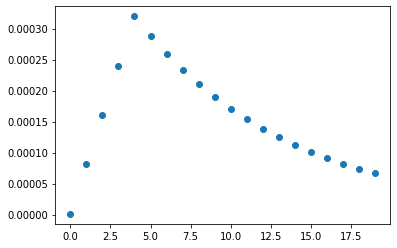

In [65]:
def get_lr_callback(plot=False, batch_size=64, epochs=20):
    lr_start   = 0.000001
    lr_max     = 0.000005 * batch_size  
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    if(plot):
        epochs = list(range(epochs))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        ax = plt.gca()
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [66]:
def pairwise_distance(embeddings, squared=False):
    dot = tf.matmul(embeddings, tf.transpose(embeddings))
    square_norm = tf.linalg.diag_part(dot)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot + tf.expand_dims(square_norm, 0)
    distances = tf.maximum(distances, 0.0)
    if(not squared):
        mask = tf.cast(tf.equal(distances, 0.0), tf.float32)
        distances = distances + mask * 1e-16
        distances = tf.sqrt(distances)
        distances = distances * (1.0 - mask)
    return distances

In [67]:
def pairwise_distance_2(embeddings, squared=False):
    reduced_squared = tf.math.reduce_sum(tf.math.square(embeddings), axis=[1], keepdims=True)
    squared_transpose = tf.math.square(tf.transpose(embeddings))
    reduced_transpose = tf.math.reduce_sum(squared_transpose, axis=[0], keepdims=True)
    distances_squared = tf.math.add(reduced_squared, reduced_transpose) - 2.0 * tf.matmul(embeddings, tf.transpose(embeddings))
    distances_squared = tf.maximum(distances_squared, 0.0)
    mask = tf.cast(tf.math.less_equal(distances_squared, 0.0), tf.float32)
    if(squared):
        distances = distances_squared
    else:
        distances = tf.math.sqrt(distances_squared + mask * 1e-16)
    distances = tf.math.multiply(distances, 1.0 - mask)
    mask_offdiag = tf.ones_like(distances) - tf.linalg.diag(tf.ones([tf.shape(embeddings)[0]]))
    distances = tf.math.multiply(distances, mask_offdiag)
    return distances

In [68]:
def pairwise_distance_3(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
      feature: 2-D Tensor of size `[number of data, feature dimension]`.
      squared: Boolean, whether or not to square the pairwise distances.
    Returns:
      pairwise_distances: 2-D Tensor of size `[number of data, number of data]`.
    """
    pairwise_distances_squared = (
        tf.math.add(
            tf.math.reduce_sum(tf.math.square(feature), axis=[1], keepdims=True),
            tf.math.reduce_sum(
                tf.math.square(tf.transpose(feature)), axis=[0], keepdims=True
            ),
        )
        - 2.0 * tf.matmul(feature, tf.transpose(feature))
    )

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = tf.math.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = tf.math.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = tf.math.sqrt(
            pairwise_distances_squared
            + tf.cast(error_mask, dtype=tf.dtypes.float32) * 1e-16
        )

    # Undo conditionally adding 1e-16.
    pairwise_distances = tf.math.multiply(
        pairwise_distances,
        tf.cast(tf.math.logical_not(error_mask), dtype=tf.dtypes.float32),
    )

    num_data = tf.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = tf.ones_like(pairwise_distances) - tf.linalg.diag(
        tf.ones([num_data])
    )
    pairwise_distances = tf.math.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances


In [69]:
def angular_distances(embeddings):
    embeddings = tf.math.l2_normalize(embeddings, axis=-1)
    angular_distances = 1 - tf.matmul(embeddings, tf.transpose(embeddings))
    angular_distances = tf.maximum(angular_distances, 0.0)
    mask_offdiag = tf.ones_like(angular_distances) - tf.linalg.diag(tf.ones([tf.shape(angular_distances)[0]]))
    angular_distances = tf.math.multiply(angular_distances, mask_offdiag)
    return angular_distances

[0.8944272 0.4472136]
[0.9701424 0.2425356]
[-0.98058057  0.19611612]
[-0.91192156  0.4103647 ]


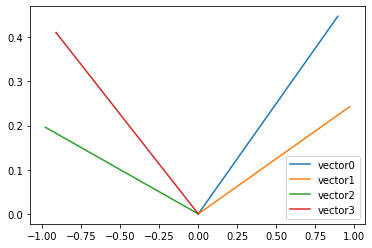

In [78]:
v1 = tf.math.l2_normalize(tf.constant([[2.0, 1.0],
                                      [2.0, 0.5],
                                      [-1.0, 0.2],
                                      [-2.0, 0.9]]), axis=-1)
v2 = tf.constant([[0],[0],[1],[1]])

labels = []
for i, vect in enumerate(v1):
    print(vect.numpy())
    labels.append(f'vector{i}')
    v = vect.numpy()
    plt.plot([0,v[0]], [0,v[1]])
plt.legend(labels)

In [79]:
pairwise_distance(v1)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.        , 0.21823359, 1.891746  , 1.8067244 ],
       [0.21823359, 0.        , 1.9512752 , 1.8895323 ],
       [1.891746  , 1.9512752 , 0.        , 0.2249811 ],
       [1.8067244 , 1.8895322 , 0.2249811 , 0.        ]], dtype=float32)>

In [80]:
pairwise_distance_2(v1)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.        , 0.21823359, 1.891746  , 1.8067244 ],
       [0.21823359, 0.        , 1.9512752 , 1.8895323 ],
       [1.891746  , 1.9512752 , 0.        , 0.2249811 ],
       [1.8067244 , 1.8895323 , 0.2249811 , 0.        ]], dtype=float32)>

In [81]:
pairwise_distance_3(v1)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.        , 0.21823359, 1.891746  , 1.8067244 ],
       [0.21823359, 0.        , 1.9512752 , 1.8895323 ],
       [1.891746  , 1.9512752 , 0.        , 0.2249811 ],
       [1.8067244 , 1.8895323 , 0.2249811 , 0.        ]], dtype=float32)>

In [82]:
angular_distances(v1)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.        , 0.02381289, 1.7893522 , 1.6321266 ],
       [0.02381289, 0.        , 1.9037379 , 1.7851657 ],
       [1.7893522 , 1.9037379 , 0.        , 0.02530837],
       [1.6321266 , 1.7851657 , 0.02530837, 0.        ]], dtype=float32)>

In [96]:
def apply_metric(embeddings, labels, metric):
    adj = tf.equal(labels, tf.transpose(labels))
    adj_not = tf.math.logical_not(adj)
    adj = tf.cast(adj, tf.float32) - tf.linalg.diag(tf.ones([tf.shape(labels)[0]]))
    adj_not = tf.cast(adj_not, tf.float32)
    distances = metric(embeddings)
    pos_dist = tf.math.multiply(distances, adj)
    print(pos_dist)
    neg_dist = tf.math.multiply(distances, adj_not)
    print(neg_dist)
    pos_dist_mean = tf.reduce_mean(tf.ragged.boolean_mask(pos_dist, mask=tf.math.equal(adj, 1.0)))
    neg_dist_mean = tf.reduce_mean(tf.ragged.boolean_mask(neg_dist, mask=tf.math.equal(adj_not, 1.0)))
    print(pos_dist_mean)
    print(neg_dist_mean)

In [97]:
apply_metric(v1, v2, angular_distances)

tf.Tensor(
[[0.         0.02381289 0.         0.        ]
 [0.02381289 0.         0.         0.        ]
 [0.         0.         0.         0.02530837]
 [0.         0.         0.02530837 0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0.        0.        1.7893522 1.6321266]
 [0.        0.        1.9037379 1.7851657]
 [1.7893522 1.9037379 0.        0.       ]
 [1.6321266 1.7851657 0.        0.       ]], shape=(4, 4), dtype=float32)
tf.Tensor(0.02456063, shape=(), dtype=float32)
tf.Tensor(1.7775955, shape=(), dtype=float32)
